# LightGBM (Light Gradient Boosting Machine)

LightGBM is a decision tree-based gradient boosting framework that improves model efficiency while reducing memory utilisation.

##### Lets Understand GBDT (Gradient Boosting Decision Tree)

GBDT is an ensemble model of decision trees which are trained in sequence(i.e. an ensemble model of boosting). In each iteration GBDT learns the decision tree by fitting the residual errors (errors upto the current iteration). This means every subsequent learner tries to learn the difference between actual output and weighted sum of predictions until an iteration before. The errors are minimised using the gradient method. The costliest operation in GBDT is training the decision tree and the most time consuming task is to find the optimum split points.

##### What are split points?

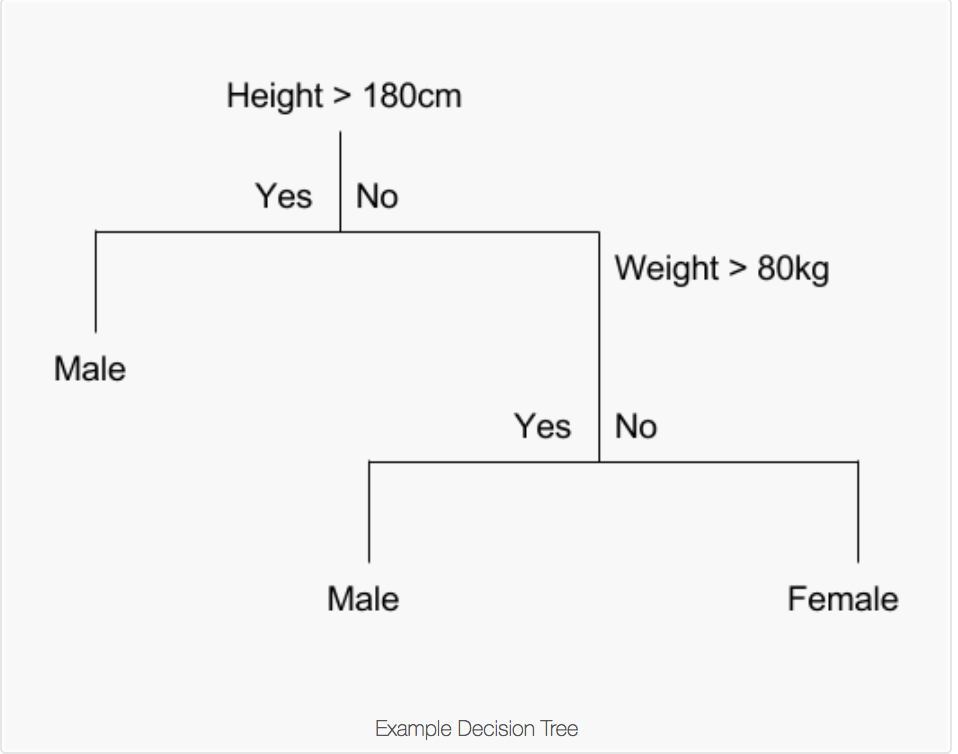

###### Split points are the feature values depending on which data is divided at a tree node. In the above example data division happens at node1 on Height ( 180 ) and at node 2 on Weight ( 80 ). The optimum splits are selected from a pool of candidate splits on the basis of information gain. In other words split points with maximum information gain are selected.

##### How are the optimum split points created?

Split finding algorithms are used to find candidate splits.
One of the most popular split finding algorithm is the Pre-sorted algorithm which enumerates all possible split points on pre-sorted values. This method is simple but highly inefficient in terms of computation power and memory .
The second method is the Histogram based algorithm which buckets continuous features into discrete bins to construct feature histograms during training. It costs O(#data * #feature) for histogram building and O(#bin * #feature) for split point finding. As bin << data histogram building will dominate the computational complexity.

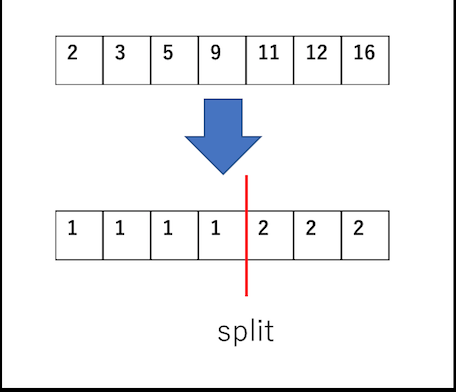

Both LightGBM and xgboost utilise histogram based split finding in contrast to sklearn which uses GBM ( One of the reasons why it is slow). Let’s begin with the crux of this post

##### LightBGM uses two techniques which fulfills the limitations of histogram-based algorithm that is primarily used in all GBDT (Gradient Boosting Decision Tree) frameworks. :- 
   1. Gradient-based One Side Sampling 
   2. Exclusive Feature Bundling (EFB)

#### 1. Gradient-based One Side Sampling 

In the computation of information gain, different data instances play different roles. The information gain will be greater for cases with bigger gradients (i.e., under-trained instances). GOSS keeps those instances with large gradients (e.g., larger than a predefined threshold, or among the top percentiles), and only randomly drop those instances with small gradients  to retain the accuracy of information gain estimation.When the value of information gain has a big range, this method can lead to a more accurate gain estimation than uniformly random sampling with the same target sample rate.

#### Mathematical Analysis for GOSS Technique

For a training set with n instances {x1, · · ·, xn}, where each xi is a vector with dimension s in space Xs. In each iteration of gradient boosting, the negative gradients of the loss function with respect to the output of the model are denoted as {g1, · · ·, gn}. In this GOSS method, the training instances are ranked according to their absolute values of their gradients in the descending order. Then, the top-a × 100% instances with the larger gradients are kept and we get an instance subset A. Then,  for the remaining set Ac consisting (1- a) × 100% instances with smaller gradients., we further randomly sample a subset B with size b × |Ac|. Finally, we split the instances according to the estimated variance gain at vector Vj (d) over the subset A ? B

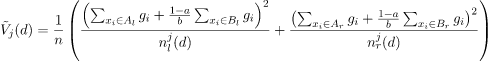

where Al = {xi ? A : xij ? d}, Ar = {xi ? A : xij > d}, Bl = {xi ? B : xij ? d}, Br = {xi ? B : xij > d}, and the coefficient (1-a)/b is used to normalize the sum of the gradients over B back to the size of Ac. 

#### Steps in GOSS calculation

1. Sort the instances according to absolute gradients in a descending order
2. Select the top a * 100% instances. [ Under trained / large gradients ]
3. Randomly samples b * 100% instances from the rest of the data. This will reduce the contribution of well trained examples by a factor of b ( b < 1 )
4. Without point 3 count of samples having small gradients would be 1-a ( currently it is b ). In order to maintain the original distribution LightGBM amplifies the contribution of samples having small gradients by a constant (1-a)/b to put more focus on the under-trained instances. This puts more focus on the under trained instances without changing the data distribution by much.

#### Algorithm

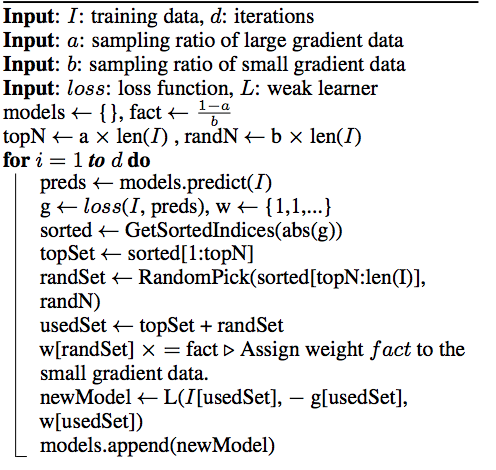

#### 2. Exclusive Feature Bundling Technique

High-dimensional data are usually very sparse which provides us a possibility of designing a nearly lossless approach to reduce the number of features. Specifically, in a sparse feature space, many features are mutually exclusive, i.e., they never take nonzero values simultaneously. The exclusive features can be safely bundled into a single feature (called an Exclusive Feature Bundle).  Hence, the complexity of histogram building changes from O(#data × #feature) to O(#data × #bundle), while #bundle<<#feature . Hence, the speed for training framework is improved without hurting accuracy. 

#### Architecture

LightGBM splits the tree leaf-wise as opposed to other boosting algorithms that grow tree level-wise. It chooses the leaf with maximum delta loss to grow. Since the leaf is fixed, the leaf-wise algorithm has lower loss compared to the level-wise algorithm. Leaf-wise tree growth might increase the complexity of the model and may lead to overfitting in small datasets.
Below is a diagrammatic representation of Leaf-Wise Tree Growth: 

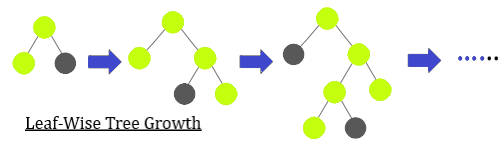

#### Merging Example

In the example below you can see that feature1 and feature2 are mutually exclusive. In order to achieve non overlapping buckets we add bundle size of feature1 to feature2. This makes sure that non zero data points of bundled features ( feature1 and feature2 ) reside in different buckets. In feature_bundle buckets 1 to 4 contains non zero instances of feature1 and buckets 5,6 contain non zero instances of feature2.

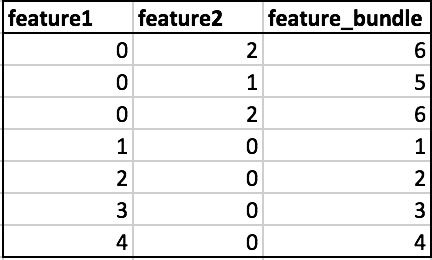

Intuitive explanation for merging features
1. Calculate the offset to be added to every feature in feature bundle.
2. Iterate over every data instance and feature.
3. Initialise the new bucket as zero for instances where all features are zero.
4. Calculate the new bucket for every non zero instance of a feature by adding respective offset to original bucket of that feature.

#### Algorithm

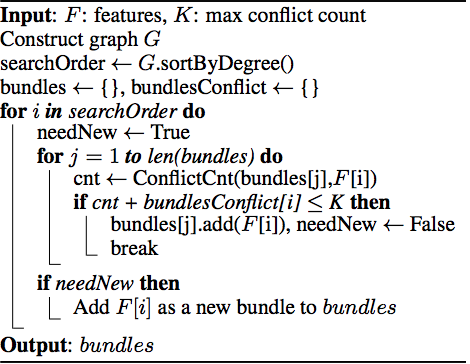

#### Parameter Tuning 

1. max_depth : It sets a limit on the depth of tree. The default value is 20. It is effective in controlling over fitting.
2. categorical_feature : It specifies the categorical feature used for training model.
3. bagging_fraction : It specifies the fraction of data to be considered for each iteration.
4. num_iterations : It specifies the number of iterations to be performed. The default value is 100.
5. num_leaves : It specifies the number of leaves in a tree. It should be smaller than the square of max_depth.
6. max_bin : It specifies the maximum number of bins to bucket the feature values.
7. min_data_in_bin : It specifies minimum amount of data in one bin.
8. task : It specifies the task we wish to perform which is either train or prediction. The default entry is train. Another possible value for this parameter is prediction.
9. feature_fraction : It specifies the fraction of features to be considered in each iteration. The default value is one.

In [1]:
!pip install lightgbm

In [2]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
import lightgbm
from sklearn.metrics import roc_auc_score
import matplotlib.pylab as plt

In [3]:
df = pd.read_csv('train.csv')
df

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,train_199995,0,11.4880,-0.4956,8.2622,3.5142,10.3404,11.6081,5.6709,15.1516,...,6.1415,13.2305,3.9901,0.9388,18.0249,-1.7939,2.1661,8.5326,16.6660,-17.8661
199996,train_199996,0,4.9149,-2.4484,16.7052,6.6345,8.3096,-10.5628,5.8802,21.5940,...,4.9611,4.6549,0.6998,1.8341,22.2717,1.7337,-2.1651,6.7419,15.9054,0.3388
199997,train_199997,0,11.2232,-5.0518,10.5127,5.6456,9.3410,-5.4086,4.5555,21.5571,...,4.0651,5.4414,3.1032,4.8793,23.5311,-1.5736,1.2832,8.7155,13.8329,4.1995
199998,train_199998,0,9.7148,-8.6098,13.6104,5.7930,12.5173,0.5339,6.0479,17.0152,...,2.6840,8.6587,2.7337,11.1178,20.4158,-0.0786,6.7980,10.0342,15.5289,-13.9001


In [4]:
var_columns = [c for c in df.columns if c not in ['ID_code','target']]

X = df.loc[:,var_columns]
y = df.loc[:,'target']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((160000, 200), (40000, 200), (160000,), (40000,))

In [5]:
train_data = lightgbm.Dataset(X_train, label=y_train)
valid_data = lightgbm.Dataset(X_valid, label=y_valid)

In [6]:
parameters = {'objective': 'binary',
              'metric': 'auc',
              'is_unbalance': 'true',
              'boosting': 'gbdt',
              'num_leaves': 63,
              'feature_fraction': 0.5,
              'bagging_fraction': 0.5,
              'bagging_freq': 20,
              'learning_rate': 0.01,
              'verbose': -1
             }

In [7]:
model_lgbm = lightgbm.train(parameters,
                            train_data,
                            valid_sets=valid_data,
                            num_boost_round=5000,
                            early_stopping_rounds=50)

C:\Users\Kishan Menaria\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's auc: 0.66387
Training until validation scores don't improve for 50 rounds
[2]	valid_0's auc: 0.691844
[3]	valid_0's auc: 0.714632
[4]	valid_0's auc: 0.720863
[5]	valid_0's auc: 0.730256
[6]	valid_0's auc: 0.744463
[7]	valid_0's auc: 0.750754
[8]	valid_0's auc: 0.761351
[9]	valid_0's auc: 0.766762
[10]	valid_0's auc: 0.770928
[11]	valid_0's auc: 0.775191
[12]	valid_0's auc: 0.777102
[13]	valid_0's auc: 0.780203
[14]	valid_0's auc: 0.783726
[15]	valid_0's auc: 0.783711
[16]	valid_0's auc: 0.784068
[17]	valid_0's auc: 0.78349
[18]	valid_0's auc: 0.783665
[19]	valid_0's auc: 0.7836
[20]	valid_0's auc: 0.783855
[21]	valid_0's auc: 0.785852
[22]	valid_0's auc: 0.786739
[23]	valid_0's auc: 0.787076
[24]	valid_0's auc: 0.78861
[25]	valid_0's auc: 0.7896
[26]	valid_0's auc: 0.791877
[27]	valid_0's auc: 0.793067
[28]	valid_0's auc: 0.793554
[29]	valid_0's auc: 0.79517
[30]	valid_0's auc: 0.795741
[31]	valid_0's auc: 0.797234
[32]	valid_0's auc: 0.79732
[33]	valid_0's auc: 0.798988


[279]	valid_0's auc: 0.855236
[280]	valid_0's auc: 0.855227
[281]	valid_0's auc: 0.8553
[282]	valid_0's auc: 0.855396
[283]	valid_0's auc: 0.855467
[284]	valid_0's auc: 0.855583
[285]	valid_0's auc: 0.855613
[286]	valid_0's auc: 0.855651
[287]	valid_0's auc: 0.855753
[288]	valid_0's auc: 0.8558
[289]	valid_0's auc: 0.85584
[290]	valid_0's auc: 0.855981
[291]	valid_0's auc: 0.856025
[292]	valid_0's auc: 0.856109
[293]	valid_0's auc: 0.856182
[294]	valid_0's auc: 0.856309
[295]	valid_0's auc: 0.856382
[296]	valid_0's auc: 0.856438
[297]	valid_0's auc: 0.856559
[298]	valid_0's auc: 0.856657
[299]	valid_0's auc: 0.85679
[300]	valid_0's auc: 0.856804
[301]	valid_0's auc: 0.856887
[302]	valid_0's auc: 0.857056
[303]	valid_0's auc: 0.857185
[304]	valid_0's auc: 0.857238
[305]	valid_0's auc: 0.857372
[306]	valid_0's auc: 0.857483
[307]	valid_0's auc: 0.857639
[308]	valid_0's auc: 0.857805
[309]	valid_0's auc: 0.857909
[310]	valid_0's auc: 0.858033
[311]	valid_0's auc: 0.858164
[312]	valid_0's 

[558]	valid_0's auc: 0.874393
[559]	valid_0's auc: 0.874401
[560]	valid_0's auc: 0.874427
[561]	valid_0's auc: 0.874479
[562]	valid_0's auc: 0.874555
[563]	valid_0's auc: 0.87462
[564]	valid_0's auc: 0.874681
[565]	valid_0's auc: 0.874767
[566]	valid_0's auc: 0.874814
[567]	valid_0's auc: 0.874885
[568]	valid_0's auc: 0.874928
[569]	valid_0's auc: 0.874976
[570]	valid_0's auc: 0.875001
[571]	valid_0's auc: 0.875082
[572]	valid_0's auc: 0.875162
[573]	valid_0's auc: 0.875245
[574]	valid_0's auc: 0.875268
[575]	valid_0's auc: 0.875311
[576]	valid_0's auc: 0.875346
[577]	valid_0's auc: 0.875352
[578]	valid_0's auc: 0.875404
[579]	valid_0's auc: 0.875459
[580]	valid_0's auc: 0.875452
[581]	valid_0's auc: 0.875492
[582]	valid_0's auc: 0.875554
[583]	valid_0's auc: 0.875606
[584]	valid_0's auc: 0.875669
[585]	valid_0's auc: 0.875725
[586]	valid_0's auc: 0.875776
[587]	valid_0's auc: 0.87581
[588]	valid_0's auc: 0.875835
[589]	valid_0's auc: 0.875907
[590]	valid_0's auc: 0.875934
[591]	valid_

[834]	valid_0's auc: 0.883843
[835]	valid_0's auc: 0.883902
[836]	valid_0's auc: 0.88391
[837]	valid_0's auc: 0.883934
[838]	valid_0's auc: 0.883939
[839]	valid_0's auc: 0.883953
[840]	valid_0's auc: 0.883999
[841]	valid_0's auc: 0.884048
[842]	valid_0's auc: 0.884077
[843]	valid_0's auc: 0.884081
[844]	valid_0's auc: 0.884105
[845]	valid_0's auc: 0.884117
[846]	valid_0's auc: 0.884107
[847]	valid_0's auc: 0.88412
[848]	valid_0's auc: 0.884134
[849]	valid_0's auc: 0.884145
[850]	valid_0's auc: 0.884184
[851]	valid_0's auc: 0.884201
[852]	valid_0's auc: 0.884199
[853]	valid_0's auc: 0.884214
[854]	valid_0's auc: 0.88425
[855]	valid_0's auc: 0.884261
[856]	valid_0's auc: 0.884296
[857]	valid_0's auc: 0.884336
[858]	valid_0's auc: 0.884351
[859]	valid_0's auc: 0.884349
[860]	valid_0's auc: 0.884392
[861]	valid_0's auc: 0.884414
[862]	valid_0's auc: 0.884437
[863]	valid_0's auc: 0.884457
[864]	valid_0's auc: 0.88449
[865]	valid_0's auc: 0.884505
[866]	valid_0's auc: 0.884546
[867]	valid_0'

[1105]	valid_0's auc: 0.88865
[1106]	valid_0's auc: 0.88868
[1107]	valid_0's auc: 0.888691
[1108]	valid_0's auc: 0.888698
[1109]	valid_0's auc: 0.888706
[1110]	valid_0's auc: 0.888723
[1111]	valid_0's auc: 0.888726
[1112]	valid_0's auc: 0.888736
[1113]	valid_0's auc: 0.888761
[1114]	valid_0's auc: 0.88879
[1115]	valid_0's auc: 0.888798
[1116]	valid_0's auc: 0.888815
[1117]	valid_0's auc: 0.888823
[1118]	valid_0's auc: 0.888837
[1119]	valid_0's auc: 0.888855
[1120]	valid_0's auc: 0.88887
[1121]	valid_0's auc: 0.888888
[1122]	valid_0's auc: 0.88889
[1123]	valid_0's auc: 0.888911
[1124]	valid_0's auc: 0.888912
[1125]	valid_0's auc: 0.888929
[1126]	valid_0's auc: 0.888954
[1127]	valid_0's auc: 0.888977
[1128]	valid_0's auc: 0.888983
[1129]	valid_0's auc: 0.889002
[1130]	valid_0's auc: 0.889027
[1131]	valid_0's auc: 0.889032
[1132]	valid_0's auc: 0.889049
[1133]	valid_0's auc: 0.889082
[1134]	valid_0's auc: 0.889087
[1135]	valid_0's auc: 0.889103
[1136]	valid_0's auc: 0.889141
[1137]	valid_

[1374]	valid_0's auc: 0.891761
[1375]	valid_0's auc: 0.891765
[1376]	valid_0's auc: 0.891776
[1377]	valid_0's auc: 0.891781
[1378]	valid_0's auc: 0.891812
[1379]	valid_0's auc: 0.89182
[1380]	valid_0's auc: 0.891828
[1381]	valid_0's auc: 0.891834
[1382]	valid_0's auc: 0.891823
[1383]	valid_0's auc: 0.891835
[1384]	valid_0's auc: 0.891845
[1385]	valid_0's auc: 0.891848
[1386]	valid_0's auc: 0.891865
[1387]	valid_0's auc: 0.891858
[1388]	valid_0's auc: 0.891877
[1389]	valid_0's auc: 0.891873
[1390]	valid_0's auc: 0.891873
[1391]	valid_0's auc: 0.891879
[1392]	valid_0's auc: 0.891889
[1393]	valid_0's auc: 0.891889
[1394]	valid_0's auc: 0.891899
[1395]	valid_0's auc: 0.891919
[1396]	valid_0's auc: 0.891924
[1397]	valid_0's auc: 0.891931
[1398]	valid_0's auc: 0.891938
[1399]	valid_0's auc: 0.891935
[1400]	valid_0's auc: 0.891933
[1401]	valid_0's auc: 0.891931
[1402]	valid_0's auc: 0.891946
[1403]	valid_0's auc: 0.891964
[1404]	valid_0's auc: 0.891961
[1405]	valid_0's auc: 0.891975
[1406]	va

[1640]	valid_0's auc: 0.893424
[1641]	valid_0's auc: 0.893426
[1642]	valid_0's auc: 0.893443
[1643]	valid_0's auc: 0.893454
[1644]	valid_0's auc: 0.893446
[1645]	valid_0's auc: 0.893457
[1646]	valid_0's auc: 0.893453
[1647]	valid_0's auc: 0.893442
[1648]	valid_0's auc: 0.893446
[1649]	valid_0's auc: 0.893429
[1650]	valid_0's auc: 0.893427
[1651]	valid_0's auc: 0.893421
[1652]	valid_0's auc: 0.89342
[1653]	valid_0's auc: 0.89342
[1654]	valid_0's auc: 0.89343
[1655]	valid_0's auc: 0.893429
[1656]	valid_0's auc: 0.89344
[1657]	valid_0's auc: 0.893458
[1658]	valid_0's auc: 0.893461
[1659]	valid_0's auc: 0.893459
[1660]	valid_0's auc: 0.893454
[1661]	valid_0's auc: 0.893463
[1662]	valid_0's auc: 0.893481
[1663]	valid_0's auc: 0.893495
[1664]	valid_0's auc: 0.893494
[1665]	valid_0's auc: 0.893496
[1666]	valid_0's auc: 0.893501
[1667]	valid_0's auc: 0.893503
[1668]	valid_0's auc: 0.89351
[1669]	valid_0's auc: 0.893519
[1670]	valid_0's auc: 0.893536
[1671]	valid_0's auc: 0.893529
[1672]	valid_

[1910]	valid_0's auc: 0.894149
[1911]	valid_0's auc: 0.894138
[1912]	valid_0's auc: 0.894136
[1913]	valid_0's auc: 0.894133
[1914]	valid_0's auc: 0.894128
[1915]	valid_0's auc: 0.894131
[1916]	valid_0's auc: 0.894131
[1917]	valid_0's auc: 0.894128
[1918]	valid_0's auc: 0.89415
[1919]	valid_0's auc: 0.894169
[1920]	valid_0's auc: 0.894161
[1921]	valid_0's auc: 0.894171
[1922]	valid_0's auc: 0.894177
[1923]	valid_0's auc: 0.894181
[1924]	valid_0's auc: 0.89419
[1925]	valid_0's auc: 0.894185
[1926]	valid_0's auc: 0.894194
[1927]	valid_0's auc: 0.894194
[1928]	valid_0's auc: 0.894191
[1929]	valid_0's auc: 0.894191
[1930]	valid_0's auc: 0.894192
[1931]	valid_0's auc: 0.894211
[1932]	valid_0's auc: 0.894205
[1933]	valid_0's auc: 0.894206
[1934]	valid_0's auc: 0.894203
[1935]	valid_0's auc: 0.894202
[1936]	valid_0's auc: 0.894198
[1937]	valid_0's auc: 0.894213
[1938]	valid_0's auc: 0.894221
[1939]	valid_0's auc: 0.894223
[1940]	valid_0's auc: 0.894225
[1941]	valid_0's auc: 0.894218
[1942]	val

[2175]	valid_0's auc: 0.894679
[2176]	valid_0's auc: 0.894684
[2177]	valid_0's auc: 0.894679
[2178]	valid_0's auc: 0.894685
[2179]	valid_0's auc: 0.894693
[2180]	valid_0's auc: 0.894701
[2181]	valid_0's auc: 0.894704
[2182]	valid_0's auc: 0.89471
[2183]	valid_0's auc: 0.894701
[2184]	valid_0's auc: 0.894702
[2185]	valid_0's auc: 0.894699
[2186]	valid_0's auc: 0.894711
[2187]	valid_0's auc: 0.894698
[2188]	valid_0's auc: 0.8947
[2189]	valid_0's auc: 0.894704
[2190]	valid_0's auc: 0.894692
[2191]	valid_0's auc: 0.894694
[2192]	valid_0's auc: 0.894697
[2193]	valid_0's auc: 0.894708
[2194]	valid_0's auc: 0.894705
[2195]	valid_0's auc: 0.894699
[2196]	valid_0's auc: 0.894712
[2197]	valid_0's auc: 0.894717
[2198]	valid_0's auc: 0.894727
[2199]	valid_0's auc: 0.89473
[2200]	valid_0's auc: 0.894728
[2201]	valid_0's auc: 0.894741
[2202]	valid_0's auc: 0.894743
[2203]	valid_0's auc: 0.894748
[2204]	valid_0's auc: 0.894756
[2205]	valid_0's auc: 0.894751
[2206]	valid_0's auc: 0.894741
[2207]	valid

In [8]:
y_train_pred = model_lgbm.predict(X_train)
y_valid_pred = model_lgbm.predict(X_valid)

print("AUC Train: {:.4f}\nAUC Valid: {:.4f}".format(roc_auc_score(y_train, y_train_pred),
                                                    roc_auc_score(y_valid, y_valid_pred)))

AUC Train: 0.9883
AUC Valid: 0.8953
